Generate Kd WAQ inputs from RS data
==

Background: 

[model_planning_Oct142022](https://docs.google.com/presentation/d/10RZtD3SvwoaoX4lbR_ElsCDLWahbzEXrsTneE0isW1o/edit#slide=id.g16777ca2c9a_2_0)

Inputs:

* RS data from Lawrence - Sentinel3
* Peterson and high-speed mapping cruises. [data from PM](https://drive.google.com/drive/u/1/folders/1CYnVrq4k-QZIGOJa_FAFw3yfvJSWaZKr)
  * `peterson`
  * `mapping`
* Moored sensor data ([data](https://drive.google.com/drive/u/1/folders/0B88Z34vUdBoHYlVOVWllaFBHUkU?resourcekey=0-TyxIX7d5F6e0QJgp6PRpkw)), [Allie's analysis](https://drive.google.com/drive/u/1/folders/1d1iVW3PFGkEhhfDe4X0R8HDNwz4dHK0P) and `L2` locally

**Additional data needs**

- Lat/Lon for Moored Sensors data
- time of satellite flyover?


Output:

* Comparison/rough calibration of RS vs. either mapping or mooring
* Kd field for DWAQ input

In [459]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [485]:
from stompy.grid import unstructured_grid
import matplotlib.pyplot as plt
from stompy.spatial import field
import xarray as xr
import numpy as np
import stompy.model.unstructured_diffuser as undiff
from stompy.spatial import interp_4d
from stompy import utils
from stompy.plot import plot_wkb
import statsmodels.formula.api as smf
import netCDF4
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from IPython.display import display, Video
from stompy.plot import mkanim
import re, datetime, glob, os
import pandas as pd
%matplotlib notebook

Load grid
--

In [461]:
# Load target grid -- pull from the grids used in the empirical Kd
# folder.
grid=unstructured_grid.UnstructuredGrid.read_dfm("../empirical_kd/Grid/wy2013c_waqgeom.nc",
                                                cleanup=True)
poly=grid.boundary_polygon()

if 0: # visual check
    plt.figure()
    grid.plot_edges(lw=0.5,color='k',alpha=0.7)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:5121 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249210, 15 potential interiors


Roster of images
--

In [462]:
glob.glob('rs/fnu_09_reproj/*/*.img')

['rs/fnu_09_reproj/projected_20220822_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220808_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220807_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220814_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220811_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220826_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220827_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220809_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220821_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220830_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220805_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220804_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220823_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220829_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220816_BandMath.data/fnu.img',
 'rs/fnu_09_reproj/projected_20220806_BandMath.data/fnu.img',
 'rs/fnu

In [463]:
df=pd.DataFrame()
#df['img_fn']=glob.glob('rs/kd_08_reproj/*/*.img')
df['img_fn']=glob.glob('rs/fnu_09_reproj/*/*.img')
# I think the fly-overs are the same time each day.
time_offset=datetime.timedelta(hours=12)
def get_date(fn):
    m=re.match(r'.*\D(20\d{6})\D.*',fn)
    if m is None:
        return None
    datestamp=m.group(1)
    return datetime.datetime.strptime(datestamp,'%Y%m%d') + time_offset
df['time']=df['img_fn'].map(get_date)

def load_img(fn):
    img=field.GdalGrid(fn)
    if 'fnu' in fn:
        missing=img.F<0.24
        img.F[missing]=np.nan
    return img
img_df=df.sort_values('time')

<IPython.core.display.Javascript object>


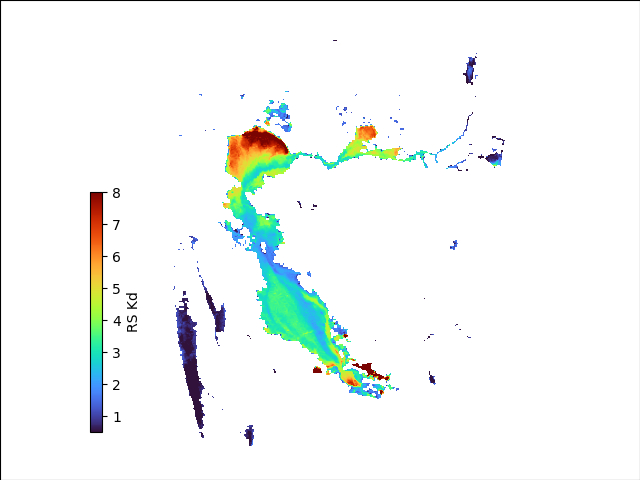

In [464]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
fig.subplots_adjust(0,0,1,1)
img=load_img(img_df['img_fn'].values[0])

art=img.plot(ax=ax,cmap='turbo')
art.set_clim([0.5,8])
plt.colorbar(art,cax=fig.add_axes([0.14,0.1,0.02,0.5]),label='RS Kd')

Mapping data
--

In [465]:
# assume mapping data times are PDT
mapping_df=pd.read_csv('mapping/summer2022_condensed.csv',
                       parse_dates=['Datetime']).rename({'Datetime':'time'},axis=1)

if 0:
    mapping_df.head()
    mapping_df['time'].dt.date.unique()
    mapping_df.columns

"Calibration"
==

In [466]:
# generate paired dataset where spatial/temporal overlap is "close"
# iterate over satellite images
# pull mapping data +-time_slop
# pad the satellite data slightly (in case of misaligned channel)
# pull satellite samples to match mapping data

# with 30h can hit more cruises, but the correlation is pretty bad. R^2~0.01
# with 2h, R^2 goes up to 0.08
time_slop=np.timedelta64(1,'h')
# expand RS data out by this number of pixels.
# R^2 is substantially better (but still bad) with no padding.
img_pad_pixels=0 

cal_dfs=[]

for _,row in img_df.iterrows():
    print(row['img_fn'],end=' ')
    map_sel=(mapping_df.time>=row['time']-time_slop)&(mapping_df.time<=row['time']+time_slop)
    if not np.any(map_sel):
        print("No overlap")
        continue
    print(f"{map_sel.sum()} overlapping mapping data")
    # This can lead to a large number of data points, say 10k.
    
    xy=mapping_df[['utm_x','utm_y']].values[map_sel]
    img=load_img(row['img_fn'])
    if img_pad_pixels:
        img.fill_by_convolution(iterations=img_pad_pixels)
    rs_data=img(xy)
    
    cal_df=mapping_df.loc[map_sel,
                          ['utm_x','utm_y','ext','ssc.mgL','Turb_FNU_exo','time']]
    cal_df['rs']=rs_data
    cal_df['hours_offset']=(row['time'] - cal_df['time'])/np.timedelta64(1,'h')
    cal_dfs.append(cal_df)    

    if 0:
        plt.figure()
        img.plot(cmap='turbo')
        plt.plot( xy[:,0], xy[:,1], 'wo',zorder=1)
        plt.scatter(xy[:,0],xy[:,1],20,rs_data,cmap='turbo',zorder=2)
        plt.plot( xy[:,0], xy[:,1], 'k-', lw=0.8,zorder=3)
        break
        
cal_df=pd.concat(cal_dfs)

rs/fnu_09_reproj/projected_20220804_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220805_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220806_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220807_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220808_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220809_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220810_BandMath.data/fnu.img 6878 overlapping mapping data
rs/fnu_09_reproj/projected_20220811_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220812_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220813_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220814_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220815_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220816_BandMath.data/fnu.img No overlap
rs/fnu_09_reproj/projected_20220818_BandMath.data/fnu.img No overlap
rs/fnu_09_repro

In [467]:
df.head()

,img_fn,time
0,rs/fnu_09_reproj/projected_20220822_BandMath.d...,2022-08-22 12:00:00
1,rs/fnu_09_reproj/projected_20220808_BandMath.d...,2022-08-08 12:00:00
2,rs/fnu_09_reproj/projected_20220807_BandMath.d...,2022-08-07 12:00:00
3,rs/fnu_09_reproj/projected_20220814_BandMath.d...,2022-08-14 12:00:00
4,rs/fnu_09_reproj/projected_20220811_BandMath.d...,2022-08-11 12:00:00


In [468]:
cal_df.time.dt.date.unique()

array([datetime.date(2022, 8, 10), datetime.date(2022, 8, 31)],
      dtype=object)

<IPython.core.display.Javascript object>


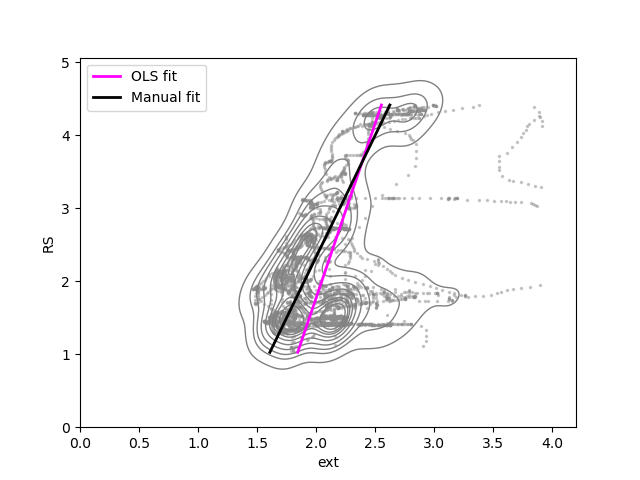

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Q('ext')   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1170.
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          7.04e-225
Time:                        04:54:41   Log-Likelihood:                -1238.0
No. Observations:                3955   AIC:                             2480.
Df Residuals:                    3953   BIC:                             2493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6290      0.014    114.628      0.000       1.601       1.657
rs             0.2092      0.006     34.208      0.000       0.197       0.221
==============================================================================
Omnibus:                     1221.672   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3923.949
Skew:                           1.566   Prob(JB):                         0.00
Kurtosis:                       6.741   Cond. No.                         7.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [469]:
# How does rs data compare to various mapping data?
fig,ax=plt.subplots()
map_field='ext'

df=cal_df

# with outliers: R2 0.146
# without outliers: 0.228, though twitchy w.r.t. percentiles

if 1:
    # heavy-handed brutal removal of outliers
    rs_max=df['rs'].quantile(0.98)
    map_max=df[map_field].quantile(0.98)

    sel=(df['rs']<rs_max)&(df[map_field]<map_max)
    df=df[sel]
    # Also tried fitting with Huber loss, with results almost identical
    # to OLS.

if 1: # further thinning
    stride=len(df)//3000
    if stride:
        df=df.iloc[::stride,:] 

fit=smf.ols(f"Q('{map_field}') ~ rs",data=df).fit()
# This is the "proper" fit. But it is not great, and captures relatively
# little variation in ext.
if 0:
    def rs_to_ext(rs,fit=fit):
        return rs*fit.params['rs'] + fit.params['Intercept']
if 1:
    def rs_to_ext(rs,fit=fit):
        m=0.30
        b=1.3
        return m*rs + b

exog=df.sort_values('rs')
endog=fit.predict(exog)
manual=rs_to_ext(exog['rs'].values)

#ax.scatter(df[map_field], df['rs'], 5, df['hours_offset'])
ax.plot(df[map_field], df['rs'], '.', color='0.55',alpha=0.4,zorder=0,ms=3)

ax.set_xlabel(map_field)
ax.set_ylabel('RS')

sns.kdeplot(data=df, x=map_field, y="rs",linewidths=1.0,colors='0.5')
ax.plot(endog,exog['rs'],color='magenta',lw=2,label='OLS fit')
ax.plot(manual,exog['rs'],color='k',lw=2,label='Manual fit')

ax.axis(xmin=0,ymin=0)

display(fit.summary())
ax.legend(loc='upper left')

Stacking RS frames
==

In [470]:
# first, make sure things look okay with a single frame, then 
# come back for the time interpolation.
for _,row in img_df.iterrows():
    break
    
img=load_img(row['img_fn'])
img.F = rs_to_ext(img.F)

# grid is finer than RS data
centers=grid.cells_centroid()
cell_vals = img(centers)

<IPython.core.display.Javascript object>


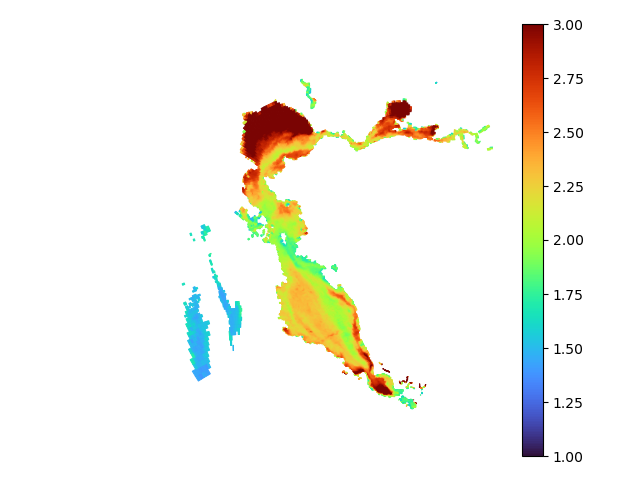

In [471]:
fig,ax=plt.subplots()

ccoll=grid.plot_cells(values=cell_vals,cmap='turbo',lw=0.7,edgecolor='face')
ccoll.set_clim([1.0,3])
plt.colorbar(ccoll)
ax.axis('off')
fig.subplots_adjust(0.05,0.05,0.95,0.95)

In [472]:
if 0: 
    # The usual weighted extrapolation gives lackluster results for RS
    # imagery. Where there is data, the data is dense and can be used directly.
    # Have to make alpha large to avoid smearing the good data.
    # But that makes the extrapolation too much like a nearest neighbor 
    # extrapolation.
    data=pd.DataFrame()
    valid=np.isfinite(cell_vals)
    data['cell']=np.nonzero(valid)[0]
    data['value']=cell_vals[valid]
    data['weight']=1.0
    # alpha=1e-5: too smeared out for RS data
    # 1e-4: still smeared
    result=interp_4d.weighted_grid_extrapolation(grid,data,cell_col='cell',alpha=1e-3)

In [473]:
def img_to_extrap_and_weight(grid,img):
    centers=grid.cells_centroid()
    cell_vals = img(centers)
    
    # Try dirichlet instead. No smoothing within the good data. Diffuse 
    # the good data out for extrapolation, and calculate a weight based
    # on diffusing the valid data mask.
    ud=undiff.Diffuser(grid)
    valid=np.isfinite(cell_vals)
    cells=np.nonzero(valid)[0]
    ud.forced_cells=set(cells)
    ud.dirichlet_bcs=[ [c,v,None] for c,v in zip(cells, cell_vals[valid])]
    result=ud.compute()

    # And again for weights:
    ud_weight=undiff.Diffuser(grid)
    ud_weight.set_decay_rate(1e-4)
    ud_weight.forced_cells=set(cells)
    ud_weight.dirichlet_bcs=[ [c,v,None] for c,v in zip(cells, np.ones_like(cells))]
    weight=ud_weight.compute().clip(0,1)
    
    return np.c_[result,weight]

In [474]:
if 1: 
    result_weight=img_to_extrap_and_weight(grid,img)
    result=result_weight[:,0]
    weight=result_weight[:,1]

Checking finite geometry
Checking finite geometry


<IPython.core.display.Javascript object>


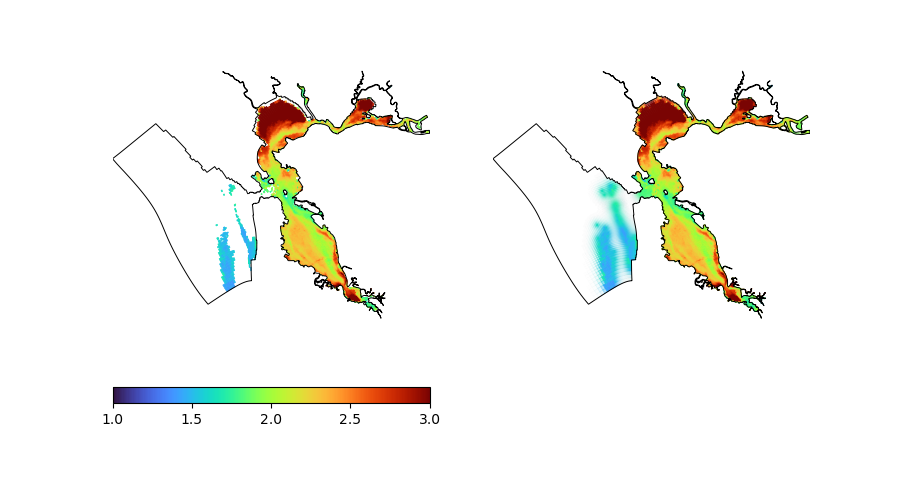

In [475]:
fig,axs=plt.subplots(1,2,figsize=(9,5))
plt.setp(axs,adjustable='datalim')

clim=[1,3]

ccoll=grid.plot_cells(values=cell_vals,cmap='turbo',lw=0.5,edgecolor='face',ax=axs[0])
ccoll.set_clim(clim)
plt.colorbar(ccoll,ax=axs[0],orientation='horizontal')

ccoll2=grid.plot_cells(values=result,cmap='turbo',lw=0.5,edgecolor='face',ax=axs[1],
                       alpha=weight)
ccoll2.set_clim(ccoll.get_clim())
ccoll2.set_clim(clim)
plt.colorbar(ccoll2,ax=axs[1],orientation='horizontal')

for ax in axs:
    plot_wkb.plot_wkb(poly,lw=0.7,edgecolor='k',ax=ax,facecolor='none')
    ax.axis('off')
    
#fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.1)

In [476]:
# Do that for each RS scene
def prep_scene(fn):
    img = load_img(fn)
    img.F = rs_to_ext(img.F)
    return img_to_extrap_and_weight(grid,img)

img_df['extrap']=img_df['img_fn'].map( prep_scene )

Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry
Checking finite geometry


In [477]:
# First cut, ignore weights, just linearly interpolate
def interp_time_linear_weightless(t):
    # if t matches exactly, gets that index.
    # otherwise returns the index of the row that comes *after* t
    i_next=img_df.time.searchsorted(t)
    i_prev=max(0,i_next-1)
    i_next=min(len(img_df)-1,i_next)
    if i_prev==i_next:
        return img_df.extrap.values[i_next][:,0]
    # writing this slightly generic, expect to extend to more nuanced
    # interpolation.
    idxs=[i_prev,i_next]
    imgs=[ img_df.extrap.values[i][:,0] for i in idxs]
    dists=[ abs(t-img_df.time.values[i]) for i in idxs]
    weights=[ dists[1]/sum(dists), dists[0]/sum(dists)]
    return imgs[0]*weights[0] + imgs[1]*weights[1]

# Second cut
def interp_time_inv_weightdist(t):
    # 25 scenes x 50k cells x {value,weight}
    stacked=np.stack([a for a in img_df['extrap'].values],axis=0)

    scene_dt_d=np.abs( (t-img_df['time'].values)/np.timedelta64(86400,'s') )
    scene_dt_d=scene_dt_d[:,None] # to broadcast against stacked

    # how to balance diffusion weight [0,1] and time offset.
    # the 'weight' distance is 1-stacked[:,:,1]
    # scale that up to 10, after squaring.
    # extrap weight=0 => like 3 days time offset.
    # but that would map weight=0 to 1, making it equal to one day.
    dist2 = scene_dt_d**2 + (1/stacked[:,:,1].clip(1e-4)-1)
    # one day off, weight ~ 1 
    weights=(dist2 + 0.05)**(-1)

    weights = weights / weights.sum(axis=0)[None,:]
    result=(weights*stacked[:,:,0]).sum(axis=0)
    return result

interp_time=interp_time_linear_weightless
#interp_time=interp_time_inv_weightdist

<IPython.core.display.Javascript object>


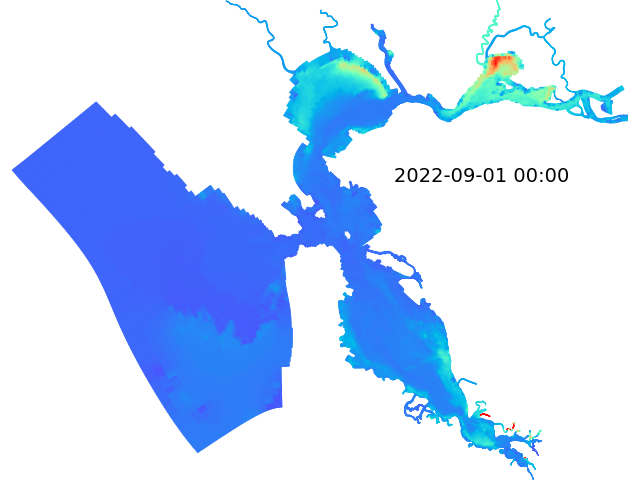

In [478]:
fig,ax=plt.subplots()

cmap=cm.rainbow
cmap=scmap.cmap_clip(cmap,0.1,1)
cmap=scmap.cmap_transform(cmap,lambda x: x**1.5)


ccoll=grid.plot_cells(values=np.ones(grid.Ncells()),cmap=cmap,lw=0.6,edgecolor='face')
ccoll.set_clim([1.2,4])

ax.axis('off')
fig.subplots_adjust(0,0,1,1)
txt=ax.text(0.62,0.62,"date",transform=ax.transAxes,fontsize=14)

t0=np.datetime64("2022-08-02")
def update(days):
    t=t0+np.timedelta64(int(days*86400),'s')
    txt.set_text( utils.to_datetime(t).strftime('%Y-%m-%d %H:%M'))
    img=interp_time(t)
    ccoll.set_array(img)
    #fig.canvas.draw()
update(14.5)

if 1: # animation
    frame_dir='rs_anim_v2'
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    patt=os.path.join(frame_dir,'frame-%04d.png')
    for i,d in enumerate(np.linspace(0,30,30*24+1)):
        update(d)
        fig.savefig(patt%i)
#interact(update,days=widgets.FloatSlider(min=0, max=30, step=0.2, value=10))

In [479]:
mp4='rs_anim_v2.mp4'
mkanim.mkanim(mp4,patt)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [480]:
Video(mp4)

Write to DWAQ
==

See `Step4_Create_DELWAQ_Input_Kd_vFineGrid.py` and also how this is used in
DWAQ runs.

 - that script generates a netcdf.

In [488]:
np.datetime64("2022-08-01").item()

datetime.date(2022, 8, 1)

In [498]:

#dwaq_output_dir="Kd_sentinel3"
#interval=np.timedelta64(1,'D')

# DWAQ isn't interpolating, and I'd rather not having glaring diurnal changes.
dwaq_output_dir="Kd_sentinel3_1h"
interval=np.timedelta64(1,'h')

# This code is essentially the same as in Step4_Create_DELWAQ_Input_Kd_vFineGrid.py,
# but leave the time as a proper CF time variable.
# Note that this code does not extrude in the vertical, just writes the 2D grid 
# and associated data. I'm not sure where in Pradeep's, Farid's or Allie's workflow
# this is handled. A quick look in Pradeep's scripts show

if not os.path.exists(dwaq_output_dir):
    os.makedirs(dwaq_output_dir)
    
t_start=np.datetime64("2022-08-01")
t_stop =np.datetime64("2022-09-01")
# output interval: daily sufficient for now.
times=np.arange(t_start, t_stop, interval)

file_output=os.path.join(dwaq_output_dir,f"Kd_sent3_{t_start.item().strftime('%Y%m%d')}_{t_stop.item().strftime('%Y%m%d')}.nc")
print(f"Writing output to {file_output}")
#%% Generate a netcdf file for DELWAQ input                                                                          
out_ds=grid.write_xarray(face_dimension='nFlowElem',edge_dimension='nNetLink',node_dimension='nNetNode')


out_ds['time']=('time',),times
out_ds.to_netcdf(file_output)
out_ds.close()
del out_ds # clean up, safe to re-open with netCDF4 for incremental write.

nc=netCDF4.Dataset(file_output,'a')
kd_var=nc.createVariable("Kd","f8",("time","nFlowElem"),                                                                                                                           
                         zlib=False,complevel=1,least_significant_digit=4)

for tidx,t in enumerate(utils.progress(times)):
    kd_var[tidx,:] = interp_time(t)
    
nc.close()


Writing output to Kd_sentinel3_1h/Kd_sent3_20220801_20220901.nc


In [499]:
import geopandas as gpd

grida=unstructured_grid.UnstructuredGrid.read_dfm("../empirical_kd/Grid/flowgeom141.nc",
                                                  cleanup=True)

gpdf = grid.write_cells_geopandas()
gpda = grida.write_cells_geopandas()
mapping = gpd.sjoin(gpdf, gpda, how="left", predicate='within')


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary


In [500]:
agg_output=file_output.replace(".nc","")+"-AggGrid_141.nc"

# And aggregated grid output
print("----- %s -----"%os.path.basename(agg_output))

light = xr.open_dataset(file_output)               

ds_new=xr.Dataset()
ds_new['time']=light.time                                                                                                   


# generally nice to keep the grid geometry nearby
grida.write_xarray(ds=ds_new,face_dimension='nFlowElem',edge_dimension='nNetLink',node_dimension='nNetNode')
ds_new.to_netcdf(agg_output)
ds_new.close()
del ds_new

nc=netCDF4.Dataset(agg_output,mode='a')
kd_var=nc.createVariable('Kd',"f8",['time','nFlowElem'])

poly_cells={} # agg polygon => array of fine grid cell indices                                                              
for i in np.arange(len(gpda)): # for each aggregated polygon                                                                
    poly_cells[i] = np.nonzero(mapping.index_right.values==i)[0] # the included high resolution grid cells                  

# Turns out it's pretty slow to load a single time index at a time. Not much extra cost
# to load 100 (or more). So go through, reading 100 times, aggregate, write out.
stride=100
def slices(N,stride=100):
    i=0
    while i<N:
        i_next=min(i+stride,N)
        yield slice(i,i_next)
        i=i_next

for ti in slices(light.dims['time']):
    print(ti)
    # area-weighted would be better, but it's not going to make a big difference.
    # this could be streamlined, but probably the cost is all in in reading the data off disk.
    #light_snap=light['Kd'].isel(time=ti).values

    light_snap=light['Kd'].isel(time=ti).values # slices, so [times,cells]

    light_snap_agg=[light_snap[...,poly_cells[i]].mean(axis=-1)
                    for i in np.arange(len(gpda))]
    # => [polygons, times]

    kd_var[ti,:]=np.array(light_snap_agg).T
nc.close()

----- Kd_sent3_20220801_20220901-AggGrid_141.nc -----
slice(0, 100, None)
slice(100, 200, None)
slice(200, 300, None)
slice(300, 400, None)
slice(400, 500, None)
slice(500, 600, None)
slice(600, 700, None)
slice(700, 744, None)
